# Learning H2O DFT Energies using Neural Networks

### Authors: Yatin Chandar, Simon Batzner - RSI 2018

### References: 

- Jon Vandermause, Steven Torrisi, Simon Batzner (https://github.com/simonbatzner/ML-electron-density)
- Brockherde, F., Vogt, L., Li, L., Tuckerman, M. E., Burke, K., & Müller, K. R. (2017). Bypassing the Kohn-Sham equations with machine learning. Nature communications, 8(1), 872.
- data from: http://quantum-machine.org/datasets/

In [65]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error

In [66]:
user = 'simon'

In [67]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

if user == 'simon': 
    H2O_pos = os.environ['RSI'] + '/water/structures.xyz' 

# read and store the separations
data_h1y = []
data_h1z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1y.append(float(line.strip()[25:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1z.append(float(line.strip()[42:52]))
        count +=1

In [68]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

if user == 'simon': 
    H2O_pos = os.environ['RSI'] + '/water/structures.xyz' 


# read and store the separations
data_h2y = []
data_h2z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2y.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2z.append(float(line.strip()[42:52]))
        count +=1
    

In [69]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

if user == 'simon': 
    H2O_pos = os.environ['RSI'] + '/water/structures.xyz' 


# read and store the separations
data_oy = []
data_oz = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oy.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oz.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [70]:
H2O_pos = '/Users/yatin/Documents/water/energies.txt'

if user == 'simon': 
    H2O_pos = os.environ['RSI'] + '/water/energies.txt' 


# read and store the separations
energy = []

with open(H2O_pos, 'r') as outf:
    for line in outf:
        energy.append(float(line))

In [71]:
bond_1 = []
bond_2 = []
side3 = []
for loc in range(0, len(data_oy)):
    bond_1.append(math.sqrt((data_oy[loc]-data_h1y[loc])**2+(data_oz[loc]-data_h1z[loc])**2))
    bond_2.append(math.sqrt((data_oy[loc]-data_h2y[loc])**2+(data_oz[loc]-data_h2z[loc])**2))
    side3.append(math.sqrt((data_h2y[loc]-data_h1y[loc])**2+(data_h2z[loc]-data_h1z[loc])**2))

In [72]:
angle = []

for location in range(0,len(data_oy)):
    angle.append(np.arccos((bond_1[location]**2+bond_2[location]**2-side3[location]**2)/(2*bond_1[location]*bond_2[location])))


In [73]:
dataset = []

for i in range (0, len(data_oy)):
    l = []
    l.append(bond_1[i])
    l.append(bond_2[i])
    l.append(angle[i])
    dataset.append(l)

In [74]:
X = dataset

In [35]:
from sklearn.cluster import KMeans

In [36]:
def split(X):
    cluster = int(input())
    model = KMeans(n_clusters=cluster)
    minsos = []
    l = []
    closepts = []
    m = []
    n = []
    closest = []
    closelbl = []
    smallest = 9999
    for i in range(50):

        model.fit(X)
        y_pred = model.predict(X)
        l = []
        m = []
        n = []
        for i in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}:
            for j in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}[i]:
                if math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2) < smallest:
                    smallest = math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2)
                    closest = dataset[j]
                    closestlabel = j
            l.append(smallest)
            m.append(closest)
            n.append(closestlabel)
            smallest = 9999
        minsos.append(l)
        closepts.append(m)
        closelbl.append(n)
    
    
    smallestsos = 9999
    sos = 0
    mark = 0
    for i in range(len(minsos)):
        sos = 0
        for j in minsos[i]:
            sos = sos+j**2
        if sos < smallestsos:
            smallestsos = sos
            mark = i
    
    trainingset = closepts[mark]
    totallbl = closelbl[mark]
    

    testset = []
    testen = []
    for k in dataset:
        testset.append(k)
    for k in energy:
        testen.append(k)
    for i in range(len(dataset)):
        for j in range(len(trainingset)):
            if trainingset[j] == dataset[i]:
                testset.remove(trainingset[j])
                testen.remove(energy[i])
    test = np.array(testset)
    testenergy = np.array(testen)
    

    A = trainingset
    B = []
    for i in totallbl:
        B.append(energy[i])
    training = np.array(A)
    trainingenergy = np.array(B)
    
    return training, trainingenergy, test, testenergy

## Split training and test data

In [102]:
training, trainingenergy, test, testenergy = split(X)

800


In [111]:
np.save('training_in_800', training)
np.save('training_out_800', trainingenergy)

np.save('test_in_200', test)
np.save('test_out_200', testenergy)

## Train Gaussian Process Regressor using scikit-learn

In [112]:
gp = GaussianProcessRegressor(n_restarts_optimizer=20)
gp.fit(training, trainingenergy)
target_pred, std = gp.predict(test, return_std=True)

/anaconda3/envs/py3.5/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [113]:
def plot_predict(pred, correct):
    plt.figure(figsize = (10, 8))
    plt.plot(pred)
    plt.plot(correct, '--')
    
def plot_scatter(pred, correct): 
    plt.figure(figsize = (15, 15))
    plt.scatter(pred, correct)
    plt.plot(np.linspace(correct.min(), correct.max()), np.linspace(correct.min(), correct.max()), 'k')
    plt.xlim((correct.min(), correct.max()))
    plt.ylim((correct.min(), correct.max()))

In [114]:
def error_det(pred, correct):
    err = mean_absolute_error(correct, pred)
    return err

In [115]:
target_pred_t = gp.predict(training)
print("MAE on training set:\t {}".format(error_det(trainingenergy, target_pred_t)))
target_pred = run_gaussian(training, trainingenergy, test)
print("MAE on test set:\t {}".format(error_det(testenergy, target_pred)))

MAE on training set:	 0.0020281254853716747
MAE on test set:	 0.002152126787132147


/anaconda3/envs/py3.5/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


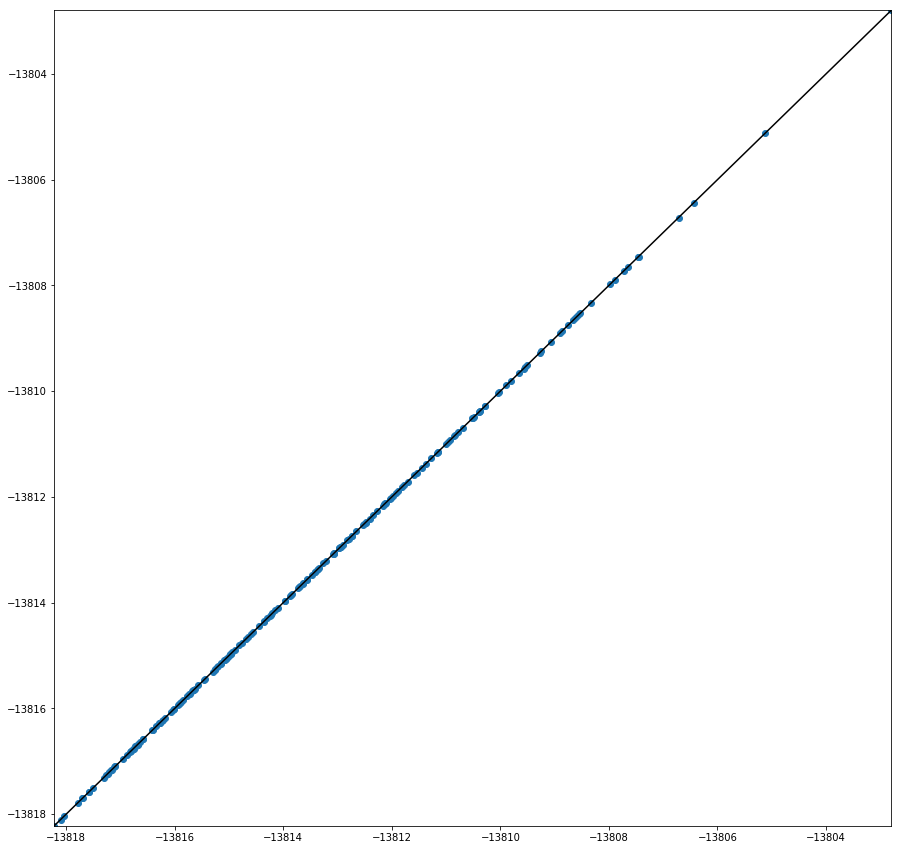

In [116]:
plot_scatter(target_pred, testenergy)

# Neural Network

In [131]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from math import sqrt

## Parameters

In [144]:
seed = 42
epochs = 50000   # maximum number of training epochs
optim = 'sgd'
lr = 0.001      # larger means faster learning, more aggressive, set this in [0.001 - 0.003]
decay = 0.0     # decay learning rate as training advances

x_train = training
y_train = trainingenergy

x_test = test
y_test =testenergy

# network architecture - for single layer, set: hidden = (n,)
hidden = (50,)

# ignore tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [139]:
def  init_architecture(input_shape, hidden_size, summary, activation='relu'):
    """
    Built Neural Network using Keras

    :param input_shape: shape of the input data
    :param hidden_size: tuple of number of hidden layers, eg. (30, 30, 40) builds a network with hidden layers 30-30-40
    :param summary: boolean, true plots a summary
    :param activation: activiation function
    :return: keras Sequential model
    """
    model = Sequential()
    print("Input shape: {}".format(input_shape))

    # hidden layers
    model.add(Dense(hidden_size[0], input_shape=input_shape, activation=activation))
    for layer_size in hidden_size[1:]:
        model.add(Dense(layer_size, activation=activation))
#         model.add(Dropout(0.2))

    # output layer
    model.add(Dense(1, activation='linear'))

    if summary:
        model.summary()

    return model

In [140]:
def train(model,  training_data, training_labels, validation_data, validation_labels, batchsize=64):
    """"
    Train Neural Network model
    """
    history = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels),
                        batch_size=batchsize,
                        verbose=0, shuffle=True)
    return history

## Build model and train

In [145]:
# build neural net
model = init_architecture(input_shape=x_train[0].shape, hidden_size=tuple(hidden), summary=True,
                          activation='tanh')

# pick optimizer
optim = 'adam'
adam = optimizers.Adam(lr=lr, decay=decay)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

# set loss function
if optim == 'adam': 
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
elif optim == 'sgd': 
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
else: 
    "Default optimizer ADAM being used..."
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
    
# early stopping on validation error (i.e. network will stop when loss on the validation set increases)
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=500,
                   verbose=10, mode='auto')

# Log graph and gradients
tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=1, write_graph=True, write_grads=True,
                 write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Save training history
history = model.fit(x_train, y_train, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[es, tb])

Input shape: (3,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 50)                200       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
Epoch 14915: early stopping


## Results

200/200 [==============================] - 0s 79us/step

MAE on training data: 	2.2648112031000482
MAE on test data: 	2.4220171893746554

		Pred 	| 	True

[[-13813.49023438 -13813.68607313]
 [-13813.49023438 -13816.6870142 ]
 [-13813.49023438 -13814.45032069]
 [-13813.49023438 -13808.54487429]
 [-13813.49023438 -13815.8740248 ]
 [-13813.49023438 -13815.05954819]
 [-13813.49023438 -13814.56499187]
 [-13813.49023438 -13813.71226853]
 [-13813.49023438 -13808.62207998]
 [-13813.49023438 -13811.89693858]
 [-13813.49023438 -13809.24987236]
 [-13813.49023438 -13813.41368359]
 [-13813.49023438 -13815.65246043]
 [-13813.49023438 -13811.92755793]
 [-13813.49023438 -13816.58475203]
 [-13813.49023438 -13812.01691222]
 [-13813.49023438 -13815.26573543]
 [-13813.49023438 -13815.15468184]
 [-13813.49023438 -13816.17334079]
 [-13813.49023438 -13809.06303439]
 [-13813.49023438 -13814.23390505]
 [-13813.49023438 -13810.38954033]
 [-13813.49023438 -13812.5220107 ]
 [-13813.49023438 -13807.72311856]
 [-13

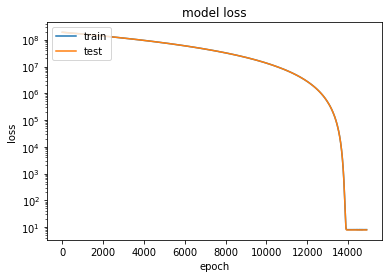

In [146]:
# Predict# Predi 
test_loss = model.evaluate(x_test, y_test)

# Eval on training data
y_true, y_pred = y_train, model.predict(x_train)
print("\nMAE on training data: \t{}".format(mean_absolute_error(y_true, y_pred)))

# Eval on test data
y_true, y_pred = y_test, model.predict(x_test)
print("MAE on test data: \t{}".format(mean_absolute_error(y_true, y_pred)))

# Predict on new data
print("\n\t\tPred \t| \tTrue\n")
print(np.c_[y_pred, y_true])

# Results
print("\n\nTest Loss: {}".format(test_loss[1]))

# Plot loss history
print(history.history.keys())
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [148]:
plot_scatter(y_pred, y_test)